# Wrangling and Analyzing WeRateDogs Twitter Dataset

# Gathering Data
- Import relevant libraries

In [1]:
#import libraries to use in this project
import requests
import os
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import time
import datetime
import io
from tweepy import OAuthHandler
from timeit import default_timer as timer

%matplotlib inline

## WeRateDogs Twitter archive
- Loading the provided twitter archive enhanced dataset

In [2]:
#load the WeRateDogs Twitter archive data(twitter_archive_enhanced.csv)
df_1 = pd.read_csv('twitter-archive-enhanced.csv')
df_1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
#number of columns and rows
df_1.shape #get number of columns and rows

(2356, 17)

## Tweet image predictions
- Downloading file containing twitter image predictions programmatically.

In [4]:
#use request library to dowload the tweet image prediction(image_prediction.tsv)
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(url.split('/')[-1], mode='wb') as file:
     file.write(response.content)
        

In [5]:
#load image_prediction.tsv
df_2= pd.read_csv('image-predictions.tsv', sep='\t')
df_2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
#number of columns and rows
df_2.shape #get number of columns and rows

(2075, 12)

## Querying twitter data
- Querying twitter data using twitter API
- Storing each tweet in as JSON data in tweet_json.txt file
- save each tweet's JSON data as a newline
- write and reading twitter JSON

In [7]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepyException as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Rate limit reached. Sleeping for: 168


Success
902: 758474966123810816
Success
903: 758467244762497024
Success
904: 758405701903519748
Success
905: 758355060040593408
Success
906: 758099635764359168
Success
907: 758041019896193024
Success
908: 757741869644341248
Success
909: 757729163776290825
Success
910: 757725642876129280
Success
911: 757611664640446465
Success
912: 757597904299253760
Success
913: 757596066325864448
Success
914: 757400162377592832
Success
915: 757393109802180609
Success
916: 757354760399941633
Success
917: 756998049151549440
Success
918: 756939218950160384
Success
919: 756651752796094464
Success
920: 756526248105566208
Success
921: 756303284449767430
Success
922: 756288534030475264
Success
923: 756275833623502848
Success
924: 755955933503782912
Success
925: 755206590534418437
Success
926: 755110668769038337
Success
927: 754874841593970688
Success
928: 754856583969079297
Success
929: 754747087846248448
Success
930: 754482103782404096
Success
931: 754449512966619136
Success
932: 754120377874386944
Success


Success
1154: 725729321944506368
Success
1155: 725458796924002305
Success
1156: 724983749226668032
Success
1157: 724771698126512129
Success
1158: 724405726123311104
Success
1159: 724049859469295616
Success
1160: 724046343203856385
Success
1161: 724004602748780546
Success
1162: 723912936180330496
Success
1163: 723688335806480385
Success
1164: 723673163800948736
Success
1165: 723179728551723008
Success
1166: 722974582966214656
Success
1167: 722613351520608256
Success
1168: 721503162398597120
Success
1169: 721001180231503872
Success
1170: 720785406564900865
Success
1171: 720775346191278080
Success
1172: 720415127506415616
Success
1173: 720389942216527872
Success
1174: 720340705894408192
Success
1175: 720059472081784833
Success
1176: 720043174954147842
Success
1177: 719991154352222208
Success
1178: 719704490224398336
Success
1179: 719551379208073216
Success
1180: 719367763014393856
Success
1181: 719339463458033665
Success
1182: 719332531645071360
Success
1183: 718971898235854848
Success
11

Success
1403: 699423671849451520
Success
1404: 699413908797464576
Success
1405: 699370870310113280
Success
1406: 699323444782047232
Success
1407: 699088579889332224
Success
1408: 699079609774645248
Success
1409: 699072405256409088
Success
1410: 699060279947165696
Success
1411: 699036661657767936
Success
1412: 698989035503689728
Success
1413: 698953797952008193
Success
1414: 698907974262222848
Success
1415: 698710712454139905
Success
1416: 698703483621523456
Success
1417: 698635131305795584
Success
1418: 698549713696649216
Success
1419: 698355670425473025
Success
1420: 698342080612007937
Success
1421: 698262614669991936
Success
1422: 698195409219559425
Success
1423: 698178924120031232
Success
1424: 697995514407682048
Success
1425: 697990423684476929
Success
1426: 697943111201378304
Success
1427: 697881462549430272
Success
1428: 697630435728322560
Success
1429: 697616773278015490
Success
1430: 697596423848730625
Success
1431: 697575480820686848
Success
1432: 697516214579523584
Success
14

Success
1652: 683498322573824003
Success
1653: 683481228088049664
Success
1654: 683462770029932544
Success
1655: 683449695444799489
Success
1656: 683391852557561860
Success
1657: 683357973142474752
Success
1658: 683142553609318400
Success
1659: 683111407806746624
Success
1660: 683098815881154561
Success
1661: 683078886620553216
Success
1662: 683030066213818368
Success
1663: 682962037429899265
Success
1664: 682808988178739200
Success
1665: 682788441537560576
Success
1666: 682750546109968385
Success
1667: 682697186228989953
Success
1668: 682662431982772225
Success
1669: 682638830361513985
Success
1670: 682429480204398592
Success
1671: 682406705142087680
Success
1672: 682393905736888321
Success
1673: 682389078323662849
Success
1674: 682303737705140231
Success
1675: 682259524040966145
Success
1676: 682242692827447297
Success
1677: 682088079302213632
Success
1678: 682059653698686977
Success
1679: 682047327939461121
Success
1680: 682032003584274432
Success
1681: 682003177596559360
Success
16

Rate limit reached. Sleeping for: 160


Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
1809: 676897532954456065
Success
1810: 676864501615042560
Success
1811: 676821958043033607
Success
1812: 676819651066732545
Success
1813: 676811746707918848
Success
1814: 676776431406465024
Success
1815: 676617503762681856
Success
1816: 676613908052996102
Success
1817: 676606785097199616
Success
1818: 676603393314578432
Success
1819: 676593408224403456
Success
1820: 676590572941893632
Success
1821: 676588346097852417
Success
1822: 676582956622721024
Success
1823: 676575501977128964
Success
1824: 676533798876651520
Success
1825: 676496375194980353
Success
1826: 676470639084101634
Success
1827: 676440007570247681
Success
1828: 676430933382295552
Success
1829: 676263575653122048
Success
1830: 676237365392908289
Success
1831: 676219687039057920
Success
18

Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
2058: 671355857343524864
Success
2059: 671347597085433856
Success
2060: 671186162933985280
Success
2061: 671182547775299584
Success
2062: 671166507850801152
Success
2063: 671163268581498880
Success
2064: 671159727754231808
Success
2065: 671154572044468225
Success
2066: 671151324042559489
Success
2067: 671147085991960577
Success
2068: 671141549288370177
Success
2069: 671138694582165504
Success
2070: 671134062904504320
Success
2071: 671122204919246848
Success
2072: 671115716440031232
Success
2073: 671109016219725825
Success
2074: 670995969505435648
Success
2075: 670842764863651840
Success
2076: 670840546554966016
Success
2077: 670838202509447168
Success
2078: 670833812859932673
Success
2079: 670832455012716544
Success
2080: 670826280409919488
Success
20

Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
2307: 666835007768551424
Success
2308: 666826780179869698
Success
2309: 666817836334096384
Success
2310: 666804364988780544
Success
2311: 666786068205871104
Success
2312: 666781792255496192
Success
2313: 666776908487630848
Success
2314: 666739327293083650
Success
2315: 666701168228331520
Success
2316: 666691418707132416
Success
2317: 666649482315059201
Success
2318: 666644823164719104
Success
2319: 666454714377183233
Success
2320: 666447344410484738
Success
2321: 666437273139982337
Success
2322: 666435652385423360
Success
2323: 666430724426358785
Success
2324: 666428276349472768
Success
2325: 666421158376562688
Success
2326: 666418789513326592
Success
2327: 666411507551481857
Success
2328: 666407126856765440
Success
2329: 666396247373291520
Success
23

In [8]:
df_3 = pd.read_json('tweet_json.txt', lines = True)[:-1]

In [9]:
df_3.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [10]:
df_3.shape

(2326, 32)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.


## Assess tweet_archive

### Visual Assessment

In [11]:
df_1

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


### Programmatic assessment

In [12]:
df_1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [13]:
df_1.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [14]:
df_1.info() #Twitter_archive_enhanced

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
#summary statistics
df_1.describe(include = 'all')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
count,2.356000e+03,7.800000e+01,7.800000e+01,2356,2356,2356,1.810000e+02,1.810000e+02,181,2297,2356.000000,2356.000000,2356,2356,2356,2356,2356
unique,NaN,NaN,NaN,2356,4,2356,NaN,NaN,181,2218,NaN,NaN,957,2,2,2,2
top,NaN,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/667152164...,NaN,NaN,None,None,None,None,None
freq,NaN,NaN,NaN,1,2221,1,NaN,NaN,1,2,NaN,NaN,745,2259,2346,2099,2326
mean,7.427716e+17,7.455079e+17,2.014171e+16,NaN,NaN,NaN,7.720400e+17,1.241698e+16,NaN,NaN,13.126486,10.455433,NaN,NaN,NaN,NaN,NaN
std,6.856705e+16,7.582492e+16,1.252797e+17,NaN,NaN,NaN,6.236928e+16,9.599254e+16,NaN,NaN,45.876648,6.745237,NaN,NaN,NaN,NaN,NaN
min,6.660209e+17,6.658147e+17,1.185634e+07,NaN,NaN,NaN,6.661041e+17,7.832140e+05,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,6.783989e+17,6.757419e+17,3.086374e+08,NaN,NaN,NaN,7.186315e+17,4.196984e+09,NaN,NaN,10.000000,10.000000,NaN,NaN,NaN,NaN,NaN
50%,7.196279e+17,7.038708e+17,4.196984e+09,NaN,NaN,NaN,7.804657e+17,4.196984e+09,NaN,NaN,11.000000,10.000000,NaN,NaN,NaN,NaN,NaN
75%,7.993373e+17,8.257804e+17,4.196984e+09,NaN,NaN,NaN,8.203146e+17,4.196984e+09,NaN,NaN,12.000000,10.000000,NaN,NaN,NaN,NaN,NaN


In [16]:
# null values
df_1.isnull()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
1,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
2,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
3,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
4,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
2352,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
2353,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
2354,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False


In [17]:
#sum of null values
df_1.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [18]:
#view of random samples of data
df_1.sample(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2209,668623201287675904,NaN,NaN,2015-11-23 02:52:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jomathan. He is not thrilled about the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668623201...,10,10,Jomathan,None,None,None,None
874,761292947749015552,NaN,NaN,2016-08-04 20:09:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Bonaparte. He's pupset because it's cloud...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/761292947...,11,10,Bonaparte,None,None,None,None
1974,673148804208660480,NaN,NaN,2015-12-05 14:35:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Fletcher. He's had a ruff night. No mo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673148804...,8,10,Fletcher,None,None,pupper,None
1339,704871453724954624,6.671522e+17,4.196984e+09,2016-03-02 03:30:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I found a forest Pipsy. 12/10 https://t.co/mIQ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704871453...,12,10,None,None,None,None,None
629,794355576146903043,NaN,NaN,2016-11-04 01:48:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Butter. She can have wh...,7.887659e+17,4.196984e+09,2016-10-19 15:37:03 +0000,https://twitter.com/dog_rates/status/788765914...,12,10,Butter,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
83,876537666061221889,NaN,NaN,2017-06-18 20:30:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I can say with the pupmost confidence that the...,NaN,NaN,NaN,https://twitter.com/mpstowerham/status/8761629...,14,10,None,None,None,None,None
1499,692187005137076224,NaN,NaN,2016-01-27 03:26:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a rare Arctic Wubberfloof. Unamused by...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692187005...,12,10,a,None,None,None,None
1050,743210557239623680,NaN,NaN,2016-06-15 22:36:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Kayla, an underground poker legend. Playe...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/743210557...,10,10,Kayla,None,None,None,None
1347,704364645503647744,NaN,NaN,2016-02-29 17:56:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Bisquick. He's a Beneplop Cumbers...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704364645...,12,10,Bisquick,None,None,None,None


In [19]:
#sum of duplicates
df_1.duplicated().sum()

0

`name column`

In [20]:
# Check name column
df_1.name.tail(15)

2341    None
2342    None
2343    None
2344    None
2345     the
2346     the
2347       a
2348       a
2349      an
2350       a
2351    None
2352       a
2353       a
2354       a
2355    None
Name: name, dtype: object

Observation:
- There are several rows with unusual names or missing names. It looks like the dog names are all capitalized, so words that begin in lowercase are not names, like "a", "an", "the"...

In [21]:
# List all names that aren't capitalized
error_names = df_1.name.str.contains('^[a-z]', regex = True)
df_1[error_names].name.value_counts().sort_index()

a               55
actually         2
all              1
an               7
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             4
life             1
light            1
mad              2
my               1
not              2
officially       1
old              1
one              4
quite            4
space            1
such             1
the              8
this             1
unacceptable     1
very             5
Name: name, dtype: int64

In [22]:
len(df_1[error_names])

109

In [23]:
#check how many sources we have
df_1.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [24]:
#check unique values in rating_numerator column
df_1.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88], dtype=int64)

### Quality issues

#### visual assessment
1. These columns contain null values:in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls

#### programmatic assessment
1. Erroneous data type for timestamp: it is an object instead of datetime

2. Erroneous data type: retweeted_status_timestamp(it is object instead of datetime)

3. Erroneous data type in the tweet id column is in int instead of string

4. Invalid/incorrect dog names in the name columns: such as 'a', 'an', 'the' etc. It's confirmed that dog names in lowercases are not correct dog names.
5. The 'doggo, 'floofer', 'pupper', and 'puppo' columns have lots of 'None' values.

6. Source' content is unreadable, there are 4 unique sources: Twitter for iPhone, Vine - Make a Scene, Twitter Web Client, TweetDeck.

7. There are tweets that having 'rating_numerator' with incorrect values, that weren't extracted well and there are some huge number of tweets with rating numerator > 10 with a maximum value 1776, which doesn't make sense.

8. Erroneous datatype rating numerator  

9. Some rating in denominator are >10 and some ratings in numerators are huge

10. columns for rating_numerator to form a column called rating.

### Tidiness issues
1. Columns for doggo, floofer, pupper and puppo are categories of different dog stages and should be in one column called 'dog stage'.


## Image predictions data (df_2)

### Visual Assessment

In [25]:
df_2

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


### Programmatic Assessment

In [26]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
df_2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [28]:
df_2.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [29]:
#view of randomsample data
df_2.sample(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
616,680191257256136705,https://pbs.twimg.com/media/CXCGVXyWsAAAVHE.jpg,1,Brittany_spaniel,0.733253,True,Welsh_springer_spaniel,0.251634,True,English_springer,0.009243,True
1955,864279568663928832,https://pbs.twimg.com/media/C_6JrWZVwAAHhCD.jpg,1,bull_mastiff,0.668613,True,French_bulldog,0.180562,True,Staffordshire_bullterrier,0.052237,True
447,674670581682434048,https://pbs.twimg.com/media/CVzpUGUWUAAo7Vn.jpg,1,malamute,0.180079,True,Eskimo_dog,0.178033,True,Siberian_husky,0.077966,True
634,681193455364796417,https://pbs.twimg.com/media/CXQV03pWYAAVniz.jpg,1,Pomeranian,0.992619,True,keeshond,0.004356,True,schipperke,0.000814,True
128,668274247790391296,https://pbs.twimg.com/media/CUYv4d2WUAAziXs.jpg,1,soft-coated_wheaten_terrier,0.406374,True,Lakeland_terrier,0.263854,True,toy_poodle,0.150844,True
846,695314793360662529,https://pbs.twimg.com/media/CaZBErSWEAEdXk_.jpg,2,Maltese_dog,0.678547,True,Lhasa,0.125046,True,Pekinese,0.048999,True
994,708130923141795840,https://pbs.twimg.com/media/CdPJUWIWIAAIchl.jpg,1,French_bulldog,0.710354,True,Chihuahua,0.262302,True,Cardigan,0.006904,True
1436,773922284943896577,https://pbs.twimg.com/media/Cr2GNdlW8AAbojw.jpg,1,Pomeranian,0.554331,True,Samoyed,0.432158,True,chow,0.003199,True
1046,713175907180089344,https://pbs.twimg.com/media/CeW1tERWAAAA9Q2.jpg,1,timber_wolf,0.503788,False,malamute,0.430624,True,Siberian_husky,0.028454,True
1562,793500921481273345,https://pbs.twimg.com/media/CwMU34YWIAAz1nU.jpg,2,golden_retriever,0.326122,True,Labrador_retriever,0.219904,True,Chesapeake_Bay_retriever,0.163366,True


**Notes**

The image predictions columns:

- tweet_id: the unique identifier for each tweet
- jpg_url: dog's image URL
- img_num: the image number that corresponded to the most confident prediction
- p1: algorithm's #1 prediction for the image in the tweet
- p1_conf: how confident the algorithm is in its #1 prediction
- p1_dog: whether or not the #1 prediction is a breed of dog
- p2: algorithm's #2 prediction for the image in the tweet
- p2_conf: how confident the algorithm is in its #2 prediction
- p2_dog: whether or not the #2 prediction is a breed of dog
- p3: algorithm's #3 prediction for the image in the tweet
- p3_conf: how confident the algorithm is in its #3 prediction
- p3_dog: whether or not the #3 prediction is a breed of dog

In [30]:
df_2.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

### Observation
- zero missing values in the image predictions dataset

### Quality issues
1. Erroneous data type: The twitter_id is int instead of string

2. Values in dog breed columns 'p1', 'p2', and 'p3' don't have consistent format, it has both lowercase and uppercase values.

### Tidiness issues
1. Multiple dog prediction

## Tweet_json data

### Visual Assessment

In [31]:
df_3

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321,2015-11-16 00:30:50+00:00,666050758794694657,666050758794694656,This is a truly beautiful English Wilson Staff...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666050754986266625, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2322,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2323,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2324,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


### Programmatic Assessment

In [32]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2326 non-null   datetime64[ns, UTC]
 1   id                             2326 non-null   int64              
 2   id_str                         2326 non-null   int64              
 3   full_text                      2326 non-null   object             
 4   truncated                      2326 non-null   bool               
 5   display_text_range             2326 non-null   object             
 6   entities                       2326 non-null   object             
 7   extended_entities              2056 non-null   object             
 8   source                         2326 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [33]:
df_3.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [34]:
df_3.tail()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
2321,2015-11-16 00:30:50+00:00,666050758794694657,666050758794694656,This is a truly beautiful English Wilson Staff...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666050754986266625, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2322,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2323,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2324,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2325,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [35]:
df_3.sample(15)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
909,2016-07-13 18:42:44+00:00,753298634498793472,753298634498793472,RT @dog_rates: This is Carly. She's actually 2...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,NaN,NaN,en,{'created_at': 'Mon Dec 28 17:12:42 +0000 2015...,NaN,NaN,NaN,NaN
1800,2015-12-14 03:08:46+00:00,676237365392908289,676237365392908288,Say hello to Winston. He has no respect for th...,False,"[0, 136]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 676237351492960256, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1393,2016-02-12 17:22:12+00:00,698195409219559425,698195409219559424,Meet Beau &amp; Wilbur. Wilbur stole Beau's be...,False,"[0, 144]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 698195403653705729, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1967,2015-12-04 01:42:26+00:00,672591762242805761,672591762242805760,This is Taz. He boxes leaves. 10/10 https://t....,False,"[0, 59]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 672591753367715843, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
113,2017-05-31 23:43:25+00:00,870063196459192321,870063196459192320,Meet Clifford. He's quite large. Also red. Goo...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 870063191304392704, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1094,2016-05-12 01:40:42+00:00,730573383004487680,730573383004487680,This is Rooney. He can't comprehend glass. 10/...,False,"[0, 67]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 730573372497772545, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
747,2016-09-18 21:33:11+00:00,777621514455814149,777621514455814144,This is Derek. You can't look at him and not s...,False,"[0, 112]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 777621500824260608, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2233,2015-11-20 03:35:20+00:00,667546741521195010,667546741521195008,Here is George. George took a selfie of his ne...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 667546741093330944, 'id_str'...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
625,2016-10-31 19:00:10+00:00,793165685325201412,793165685325201408,This is Benji. He's Air Bud. It's a low effort...,False,"[0, 128]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 793165673107161088, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1954,2015-12-05 02:23:49+00:00,672964561327235073,672964561327235072,This is Terry. He's a Toasty Western Sriracha....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 672964555207757826, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [36]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2326 non-null   datetime64[ns, UTC]
 1   id                             2326 non-null   int64              
 2   id_str                         2326 non-null   int64              
 3   full_text                      2326 non-null   object             
 4   truncated                      2326 non-null   bool               
 5   display_text_range             2326 non-null   object             
 6   entities                       2326 non-null   object             
 7   extended_entities              2056 non-null   object             
 8   source                         2326 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

### Quality issues
1. Erroneous data type: id column is int instead of string

2. Missing values: in_reply_to_status_id,in_reply_to_status_id_str, in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name, user, coordinates, place, contributors, possibly_sensitive,possibly_sensitive_appealable,   retweeted_status, quoted_status_id, quoted_status_id_str	quoted_status_permalink	quoted_status,  extended_entities


### Tidiness issues
1. The column label for IDs should be the same across all the three datasets

### General Assessment: Tidiness issues

1. We have three different datasets

## Overview of the data assessment

### Data Quality issues

`df_1(twitter_archive_enhanced)`

#### visual assessment
1. These columns contain null values:in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls

#### programmatic assessment
1. Erroneous data type for timestamp: it is an object instead of datetime

2. Erroneous data type: retweeted_status_timestamp(it is object instead of datetime)

3. Erroneous data type in the tweet id column is in int instead of string

4. Invalid/incorrect dog names in the name columns: such as 'a', 'an', 'None'
5. The 'doggo, 'floofer', 'pupper', and 'puppo' columns have lots of 'None' values.

6. Source' content is unreadable, there are 4 unique sources: Twitter for iPhone, Vine - Make a Scene, Twitter Web Client, TweetDeck.

7. There are tweets that having 'rating_numerator' with incorrect values, that weren't extracted well and there are some huge number of tweets with rating numerator > 10 with a maximum value 1776, which doesn't make sense.

8. Erroneous datatype rating numerator

9. Some rating in denominator are >10 and some ratings in numerators are huge

10. columns for rating_numerator to form a column called rating.


`df_2(image predictions)`

1. Erroneous data type: The twitter_id is int instead of string

2. Values in columns 'p1', 'p2', and 'p3' don't have consistent format, it has both lowercase and uppercase values.

`df_3(tweet_json)`

1. Erroneous data type: id column is int instead of string

2. Missing values: in_reply_to_status_id,in_reply_to_status_id_str, in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name

3. Missing values in user, coordinates, place, contributors, possibly_sensitive,possibly_sensitive_appealable.

4. Missing values in retweeted_status, quoted_status_id, quoted_status_id_str	quoted_status_permalink	quoted_status and,  extended_entities

### General Assesement
`tweet_json` and `tweet_archive`
1. unnecessary columns in tweet_json dataset: 'created_at','id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id','in_reply_to_status_id_str','in_reply_to_user_id ','in_reply_to_user_id_str',' in_reply_to_screen_name ','user', 'geo','coordinates','place','contributors',' is_quote_status','possibly_sensitive','possibly_sensitive_appealable','lang',' retweeted_status', 'quoted_status_id','quoted_status_id_str','quoted_status_permalink','quoted_status'

### Tidiness issues

`df_1(twitter_archive_enhanced)`

1. Columns for doggo, floofer, pupper and puppo are categories of different dog stages and should be in one column called 'dog stage'.


`df_2(image predictions)`
1. Multiple dog prediction

`df_3(tweet_json)`
1. The column label for IDs should be the same across all the three datasets

### General Assessment: Tidiness issues

1. We have three different datasets

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [37]:
# Making a copy of each dataset
df_1_clean = df_1.copy()
df_2_clean = df_2.copy()
df_3_clean = df_3.copy()

## df_1(twitter_archive_enhanced)

In [38]:
df_1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

### Issue #1:
 `Missing data`
- compute the completeness issue by dropping columns with missing values since they will not be used in analysis. Plus most of those columns have a lot of missing values.

#### Define:
- columns containing `null values`:in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls  will de dropped.

#### Code

In [39]:
#drop columns with missing values
df_1_clean = df_1_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'], axis =1)

#### Test

In [40]:
#confirm if columns dropped above are gone
df_1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   rating_numerator    2356 non-null   int64 
 5   rating_denominator  2356 non-null   int64 
 6   name                2356 non-null   object
 7   doggo               2356 non-null   object
 8   floofer             2356 non-null   object
 9   pupper              2356 non-null   object
 10  puppo               2356 non-null   object
dtypes: int64(3), object(8)
memory usage: 202.6+ KB


In [41]:
#random view of twitter_archive data
df_1_clean.sample(10)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1102,735274964362878976,2016-05-25 01:03:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please stop sending in your...,11,10,None,None,None,None,None
1406,699088579889332224,2016-02-15 04:31:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Charl. He's a bully. Chucks that dumbb...,3,10,Charl,None,None,None,None
558,803321560782307329,2016-11-28 19:35:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Philbert. His toilet br...,11,10,Philbert,None,None,None,None
1260,710269109699739648,2016-03-17 00:58:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The squad is back for St. Patrick's Day! ☘ 💚\n...,13,10,None,None,None,None,None
2269,667509364010450944,2015-11-20 01:06:48 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This a Norwegian Pewterschmidt named Tickles. ...,12,10,None,None,None,None,None
1656,683357973142474752,2016-01-02 18:43:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Have a seat, son. There are some things we ne...",10,10,None,None,None,None,None
1622,684914660081053696,2016-01-07 01:49:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Hello yes I'll just get one of each color tha...",12,10,None,None,None,None,None
1194,717428917016076293,2016-04-05 19:09:17 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Skittle. He's trying to communicate. 1...,11,10,Skittle,None,None,None,None
2072,671109016219725825,2015-11-29 23:30:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Toby. He asked for chocolate cake for ...,8,10,Toby,None,None,None,None
361,829501995190984704,2017-02-09 01:27:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Leo. He was a skater pup. She said see...,12,10,Leo,None,None,None,None


### Issue #2:

`Erroneous datatype for timestamp and retweeted_status_timestamp: object instead of datetime`


#### Define:
- Convert timestamp datatype from object to datetime.
- The retweet_status_timestamp column is already dropped. 

#### Code

In [42]:
#convert timestamp datatype from object to datetime
df_1_clean['timestamp']= pd.to_datetime(df_1_clean['timestamp'])

In [43]:
#rename 'timestamp column' to 'tweetdate'
df_1_clean.rename(columns={'timestamp':"tweet_date"}, inplace=True)

#### Test

In [44]:
#check for the format of 'timestamp' column
df_1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   int64              
 1   tweet_date          2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   rating_numerator    2356 non-null   int64              
 5   rating_denominator  2356 non-null   int64              
 6   name                2356 non-null   object             
 7   doggo               2356 non-null   object             
 8   floofer             2356 non-null   object             
 9   pupper              2356 non-null   object             
 10  puppo               2356 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3), object(7)
memory usage: 202.6+ KB


## Issue #3
`Erroneous data type in the tweet id column is in int instead of string`

#### Define
- Convert tweet_id column data type from int to string

#### Code

In [45]:
#convert tweet_id from int to string
df_1_clean['tweet_id'] = df_1_clean['tweet_id'].astype(str)

#### Test

In [46]:
#check the format of tweet_id
df_1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   object             
 1   tweet_date          2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   rating_numerator    2356 non-null   int64              
 5   rating_denominator  2356 non-null   int64              
 6   name                2356 non-null   object             
 7   doggo               2356 non-null   object             
 8   floofer             2356 non-null   object             
 9   pupper              2356 non-null   object             
 10  puppo               2356 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(8)
memory usage: 202.6+ KB


## Issue #4
`Invalid/incorrect dog names in the name columns: such as 'a', 'an', 'the' etc,`

#### Define
- Replace the wrong names for dogs which are in lowercase with NaN values

#### Code

In [47]:
 #replace the lowercase names with NaN values
df_1_clean['name'] = df_1_clean['name'].apply(lambda x: x if str(x).lower() != x else np.nan)

In [48]:
df_1_clean[df_1_clean.name.str.lower() == df_1_clean.name].name.unique()

array([], dtype=object)

In [49]:
# check value counts in 'name' column
df_1_clean['name'].value_counts()

None          745
Charlie        12
Lucy           11
Cooper         11
Oliver         11
             ... 
Devón           1
Gert            1
Dex             1
Ace             1
Christoper      1
Name: name, Length: 932, dtype: int64

In [50]:
#replace 'None' values with NaN values in the name column
df_1_clean['name'] = df_1_clean['name'].replace('None', np.NaN)

#### Test

In [51]:
#list of names
df_1_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', nan, 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot',
       'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Emmy',
       'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja', 'Penny',
       'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget',
       'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra', 'Monkey',
       'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn', 'Boomer',
       'Cody', 'Rumble', 'Clifford', 'Dewey', 'Scout', 'Gizmo', 'Cooper',
       'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy', 'Meatball',
       'Paisley', 'Albus', 'Neptune', 'Quinn', 'Belle', 'Zooey',

In [52]:
#check if the lowercase values in the 'name' column has been replaced
df_1_clean.name.tail(15)

2341    NaN
2342    NaN
2343    NaN
2344    NaN
2345    NaN
2346    NaN
2347    NaN
2348    NaN
2349    NaN
2350    NaN
2351    NaN
2352    NaN
2353    NaN
2354    NaN
2355    NaN
Name: name, dtype: object

In [53]:
# check value counts in 'name' column
df_1_clean['name'].value_counts()

Charlie       12
Lucy          11
Cooper        11
Oliver        11
Lola          10
              ..
Devón          1
Gert           1
Dex            1
Ace            1
Christoper     1
Name: name, Length: 931, dtype: int64

In [54]:
#check if 'None' values in the 'name' columns have been replaced
df_1_clean.name.tail(15)

2341    NaN
2342    NaN
2343    NaN
2344    NaN
2345    NaN
2346    NaN
2347    NaN
2348    NaN
2349    NaN
2350    NaN
2351    NaN
2352    NaN
2353    NaN
2354    NaN
2355    NaN
Name: name, dtype: object

## Issue #5
`The 'doggo, 'floofer', 'pupper', and 'puppo' columns have lots of 'None' values.`

#### Define
- replace the 'None' values with NaN values

#### Code

In [55]:
#replace 'None' with NaN values in doggo, floofer, pupper, puppo
df_1_clean['doggo'] = df_1_clean['doggo'].replace('None', np.NaN)
df_1_clean['floofer'] = df_1_clean['floofer'].replace('None', np.NaN)
df_1_clean['pupper'] = df_1_clean['pupper'].replace('None', np.NaN)
df_1_clean['puppo'] = df_1_clean['puppo'].replace('None', np.NaN)

#### Test

In [56]:
#confirm if None values are gone
df_1_clean[['doggo', 'floofer', 'pupper', 'puppo']].sample(50)

,doggo,floofer,pupper,puppo
769,NaN,NaN,NaN,NaN
1301,NaN,NaN,NaN,NaN
1858,NaN,NaN,NaN,NaN
191,doggo,NaN,NaN,puppo
1106,NaN,NaN,NaN,NaN
1804,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN
1537,NaN,NaN,NaN,NaN
1434,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN


## Issue #6
- Source' content is unreadable, there are 4 unique sources: Twitter for iPhone, Vine - Make a Scene, Twitter Web Client, TweetDeck.

#### Define
- Rename values in source column to iPhone, WebClient, Vine, TweetDeck

#### Code

In [57]:
#replace the href link for source with iPhone, WebClient, Vine, and TweetDeck
df_1_clean.source.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'iPhone', inplace = True)
df_1_clean.source.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'WebClient', inplace = True)
df_1_clean.source.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 'Vine', inplace = True)
df_1_clean.source.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'TweetDeck', inplace = True)

#### Test

In [58]:
#confirm if href link in source has been replaced
df_1_clean.source.sample(50)

131     iPhone
1761    iPhone
2095    iPhone
89      iPhone
1981    iPhone
117     iPhone
854     iPhone
2038    iPhone
1226    iPhone
1087    iPhone
848     iPhone
464     iPhone
1006      Vine
406     iPhone
90      iPhone
1929    iPhone
624     iPhone
1411    iPhone
1443      Vine
58      iPhone
1507    iPhone
275     iPhone
1706      Vine
39      iPhone
762     iPhone
1934    iPhone
884     iPhone
2153    iPhone
1754    iPhone
451     iPhone
588     iPhone
1349      Vine
2005    iPhone
526     iPhone
2221    iPhone
1686    iPhone
1101    iPhone
625     iPhone
1467    iPhone
2158    iPhone
1212    iPhone
222     iPhone
54      iPhone
997     iPhone
1214    iPhone
346     iPhone
1110    iPhone
1586      Vine
501     iPhone
370     iPhone
Name: source, dtype: object

In [59]:
df_1_clean.source.value_counts()

iPhone       2221
Vine           91
WebClient      33
TweetDeck      11
Name: source, dtype: int64

## Issue #7
- There are tweets that having 'rating_numerator' with incorrect values, that weren't extracted well and there are some huge number of tweets with rating numerator > 10 with a maximum value 1776, which doesn't make sense.

#### Define
- Extract numerator rating from text column and denominator rating

#### Code

In [60]:
#Extract rating numerators from 'text' column
df_1_clean[['rating_numerator', 'rating_denominator']] = df_1_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)',expand=True)

#### Test

In [61]:
#check value count
df_1_clean['rating_numerator'].value_counts()

12       558
11       464
10       461
13       351
9        158
8        102
7         54
14        54
5         35
6         32
3         19
4         17
2          9
1          9
9.75       2
0          2
15         2
420        2
99         1
144        1
13.5       1
11.26      1
9.5        1
20         1
121        1
143        1
44         1
60         1
45         1
80         1
204        1
50         1
007        1
1776       1
165        1
17         1
11.27      1
666        1
182        1
24         1
960        1
84         1
88         1
Name: rating_numerator, dtype: int64

In [62]:
#check value count
df_1_clean['rating_denominator'].value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
00        1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

## Issue #8
-Erroneous datatype rating numerator and denominator rating

#### Define
- convert the numerator and denominator rating data type from int to float

#### Code

In [63]:
# Convert the data type in 'rating_numerator' and 'rating_denominator' columns to float
df_1_clean['rating_numerator']= df_1_clean['rating_numerator'].astype(float)
df_1_clean['rating_denominator']= df_1_clean['rating_denominator'].astype(float)

#### Test

In [64]:
#confirm if rating datatype has changed to float
type(df_1_clean.rating_numerator[0])

numpy.float64

In [65]:
type(df_1_clean.rating_denominator[0])

numpy.float64

## Issue #9
- Some rating in denominator are >10 and some ratings in numeratora are huge

#### Define
- To normalize the data, keep rows where numerator is between 1-14 and denominator is equal to 10

#### Code

In [66]:
# Keep only rows where numerator is between 1-14 and the denominator is 10
df_1_clean = df_1_clean[(df_1_clean.rating_numerator > 0) & (df_1_clean.rating_numerator < 15) &
                          (df_1_clean.rating_denominator == 10)]

#### Test

In [67]:
#check if denominor is 10 and numerator is between 1-14
df_1_clean.describe()

,rating_numerator,rating_denominator
count,2323.000000,2323.0
mean,10.715037,10.0
std,2.144453,0.0
min,1.000000,10.0
25%,10.000000,10.0
50%,11.000000,10.0
75%,12.000000,10.0
max,14.000000,10.0


## Issue #10
 - columns for rating_numerator to form a column called rating.

#### Define
- Drop the rating_denominator column: all values in the rating_denominator column are equal to 10 hence no need for this column anymore
- Rename the rating_numerator column to 'rating'

#### Code

In [68]:
# Drop 'rating_denominator'column
df_1_clean.drop(['rating_denominator'], axis = 1, inplace = True)

In [69]:
#rename 'rating_numerator' to 'rating'
df_1_clean.rename(columns={'rating_numerator':"rating"}, inplace=True)

#### Test

In [70]:
#check if 'rating denominator' column is gone and 'rating_numerator' column renamed
df_1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2323 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   tweet_id    2323 non-null   object             
 1   tweet_date  2323 non-null   datetime64[ns, UTC]
 2   source      2323 non-null   object             
 3   text        2323 non-null   object             
 4   rating      2323 non-null   float64            
 5   name        1498 non-null   object             
 6   doggo       97 non-null     object             
 7   floofer     10 non-null     object             
 8   pupper      257 non-null    object             
 9   puppo       30 non-null     object             
dtypes: datetime64[ns, UTC](1), float64(1), object(8)
memory usage: 199.6+ KB


# Cleaning Tidiness issues in df_1(tweet_archive)

## Issue #1
 - Columns for doggo, floofer, pupper and puppo are categories of different dog stages and should be in one column called 'dog stage'.

#### Define
- Convert columns for doggo, floofer, pupper and puppo into rows

#### Code

In [71]:
# use the pd.melt() method to convert the columns into rows
dog_stage = pd.melt(df_1_clean, id_vars='tweet_id', value_vars=['doggo','floofer','pupper','puppo'], value_name='stage')

#### Test

In [72]:
dog_stage.head()

,tweet_id,variable,stage
0,892420643555336193,doggo,NaN
1,892177421306343426,doggo,NaN
2,891815181378084864,doggo,NaN
3,891689557279858688,doggo,NaN
4,891327558926688256,doggo,NaN


In [73]:
dog_stage.shape

(9292, 3)

In [74]:
#query one 'tweet_id' column to check rows in each tweet_id column
dog_stage[dog_stage['tweet_id']=='892420643555336193']

,tweet_id,variable,stage
0,892420643555336193,doggo,NaN
2323,892420643555336193,floofer,NaN
4646,892420643555336193,pupper,NaN
6969,892420643555336193,puppo,NaN


In [75]:
#drop variable column in 'dog_stage' to help identify the duplicates
dog_stage.drop('variable', axis=1, inplace=True)

In [76]:
#check if variable column has been dropped
dog_stage.head()

,tweet_id,stage
0,892420643555336193,NaN
1,892177421306343426,NaN
2,891815181378084864,NaN
3,891689557279858688,NaN
4,891327558926688256,NaN


In [77]:
#the pd.melt() created four rows for each tweet_id thus creating duplicates
#drop duplicated values
dog_stage.drop_duplicates(inplace=True)

In [78]:
#confirm that duplicates are gone
dog_stage

,tweet_id,stage
0,892420643555336193,NaN
1,892177421306343426,NaN
2,891815181378084864,NaN
3,891689557279858688,NaN
4,891327558926688256,NaN
...,...,...
7903,752519690950500352,puppo
7917,751132876104687617,puppo
7989,744995568523612160,puppo
8002,743253157753532416,puppo


Note:
- number of rows now make more sense

In [79]:
#sum of null values 
dog_stage.isnull().sum()

tweet_id       0
stage       2323
dtype: int64

In [80]:
#check the number of tweets in the 'dog_stge'
dog_stage.shape

(2717, 2)

In [81]:
#check the number of tweets in df_1_clean
df_1_clean.shape

(2323, 10)

Observation
- some tweets seem to have more than one dog stage.
- Let's join the stages using a comma

### Combine rows that have more than one do stage

In [82]:
# filter out the tweets that have actual values
has_dog_stage = dog_stage[dog_stage.stage.notna()]

In [83]:
# filter out the tweets that have more than one dog stage
more_than_one_stage = has_dog_stage[has_dog_stage.duplicated(subset = 'tweet_id', keep=False)]
more_than_one_stage.sort_values('tweet_id')

,tweet_id,stage
1097,733109485275860992,doggo
5743,733109485275860992,pupper
1048,741067306818797568,doggo
5694,741067306818797568,pupper
5589,751583847268179968,pupper
943,751583847268179968,doggo
877,759793422261743616,doggo
5523,759793422261743616,pupper
810,770093767776997377,doggo
5456,770093767776997377,pupper


In [84]:
more_than_one_stage[more_than_one_stage['tweet_id']== '855851453814013952']

,tweet_id,stage
188,855851453814013952,doggo
7157,855851453814013952,puppo


In [85]:
# join tweets with more than one dog stage with commas
combined_dog_stages = more_than_one_stage.groupby('tweet_id').transform(lambda x: ', '.join(x))
combined_dog_stages

,stage
188,"doggo, puppo"
197,"doggo, floofer"
450,"doggo, pupper"
520,"doggo, pupper"
554,"doggo, pupper"
564,"doggo, pupper"
694,"doggo, pupper"
722,"doggo, pupper"
767,"doggo, pupper"
810,"doggo, pupper"


In [86]:
list_index = combined_dog_stages.reset_index()
indexes = [i for i in list_index['index']]
for i in indexes:
    dog_stage['stage'].loc[i] = combined_dog_stages['stage'].loc[i]


In [87]:
#check if 'combine stage' has replaced in 'stage' 
dog_stage.iloc[188]

tweet_id    855851453814013952
stage             doggo, puppo
Name: 188, dtype: object

In [88]:
dog_stage.shape

(2717, 2)

In [89]:
# check if the dog stages have been accurately replaced
dog_stage.stage.unique()

array([nan, 'doggo', 'doggo, puppo', 'doggo, floofer', 'doggo, pupper',
       'floofer', 'pupper', 'puppo'], dtype=object)

### Sort values by `dog_stage` column

In [90]:
#sorting values by stage column to push tweets with null values to the bottom
dog_stage.query('tweet_id == "855851453814013952"').sort_values(by='stage')

,tweet_id,stage
188,855851453814013952,"doggo, puppo"
7157,855851453814013952,"doggo, puppo"
2511,855851453814013952,NaN


In [91]:
dog_stage.sort_values(by='stage', inplace=True)
dog_stage

,tweet_id,stage
9,890240255349198849,doggo
865,760893934457552897,doggo
845,763956972077010945,doggo
827,767191397493538821,doggo
823,768193404517830656,doggo
...,...,...
3447,727644517743104000,NaN
3462,724771698126512129,NaN
3481,719991154352222208,NaN
3508,716080869887381504,NaN


In [92]:
#drop duplicates by 'tweet_id' column
dog_stage.drop_duplicates(subset='tweet_id', inplace=True)

In [93]:
#check number of rows after dropping duplicates
dog_stage.shape

(2323, 2)

The clean `stage` column can now be merged with the main data frame(df_1_clean)

### Merge the stage column with the df_1_clean datadrame

In [94]:
#merge the stage column to the df_1_clean table
df_1_clean = pd.merge(df_1_clean, dog_stage, on =['tweet_id'], how = 'left')

In [95]:
#confirm if the stage column has been added to the df_1_clean table
df_1_clean

,tweet_id,tweet_date,source,text,rating,name,doggo,floofer,pupper,puppo,stage
0,892420643555336193,2017-08-01 16:23:56+00:00,iPhone,This is Phineas. He's a mystical boy. Only eve...,13.0,Phineas,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,iPhone,This is Tilly. She's just checking pup on you....,13.0,Tilly,NaN,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,iPhone,This is Archie. He is a rare Norwegian Pouncin...,12.0,Archie,NaN,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,iPhone,This is Darla. She commenced a snooze mid meal...,13.0,Darla,NaN,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,iPhone,This is Franklin. He would like you to stop ca...,12.0,Franklin,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2318,666049248165822465,2015-11-16 00:24:50+00:00,iPhone,Here we have a 1949 1st generation vulpix. Enj...,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2319,666044226329800704,2015-11-16 00:04:52+00:00,iPhone,This is a purebred Piers Morgan. Loves to Netf...,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2320,666033412701032449,2015-11-15 23:21:54+00:00,iPhone,Here is a very happy pup. Big fan of well-main...,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2321,666029285002620928,2015-11-15 23:05:30+00:00,iPhone,This is a western brown Mitsubishi terrier. Up...,7.0,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
df_1_clean.shape

(2323, 11)

In [97]:
#### Drop columns 'doggo', 'floofer', 'pupper', 'puppo' from df_1_clean
df_1_clean = df_1_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis =1)

In [98]:
#check if the 'doggo', 'floofer', 'pupper', 'puppo' columns are gone
df_1_clean

,tweet_id,tweet_date,source,text,rating,name,stage
0,892420643555336193,2017-08-01 16:23:56+00:00,iPhone,This is Phineas. He's a mystical boy. Only eve...,13.0,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,iPhone,This is Tilly. She's just checking pup on you....,13.0,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,iPhone,This is Archie. He is a rare Norwegian Pouncin...,12.0,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,iPhone,This is Darla. She commenced a snooze mid meal...,13.0,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,iPhone,This is Franklin. He would like you to stop ca...,12.0,Franklin,NaN
...,...,...,...,...,...,...,...
2318,666049248165822465,2015-11-16 00:24:50+00:00,iPhone,Here we have a 1949 1st generation vulpix. Enj...,5.0,NaN,NaN
2319,666044226329800704,2015-11-16 00:04:52+00:00,iPhone,This is a purebred Piers Morgan. Loves to Netf...,6.0,NaN,NaN
2320,666033412701032449,2015-11-15 23:21:54+00:00,iPhone,Here is a very happy pup. Big fan of well-main...,9.0,NaN,NaN
2321,666029285002620928,2015-11-15 23:05:30+00:00,iPhone,This is a western brown Mitsubishi terrier. Up...,7.0,NaN,NaN


# Cleaning df_2(Image_predictions)

In [99]:
df_2_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


## Quality Issues

## Issue #1
- Erroneous data type: The twitter_id is int instead of string

#### Define
- convert twitter_id column datatype from int to string

#### Code

In [100]:
#convert twitter_id column datatype from int to string 
df_2_clean['tweet_id'] = df_2_clean['tweet_id'].astype(str)

#### Test

In [101]:
df_2_clean.dtypes

tweet_id     object
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

## Issue #2
- Values in columns 'p1', 'p2', and 'p3' don't have consistent format, it has both lowercase and uppercase values.

#### Define
- remove '_' and capitalize names in p1, p2, p3 columns.

#### Code

In [102]:
#Remove '_' in p1, p2, p3 columns
df_2_clean['p1'] = df_2_clean['p1'].str.replace('_', " ")
df_2_clean['p2'] = df_2_clean['p2'].str.replace('_', " ")
df_2_clean['p3'] = df_2_clean['p3'].str.replace('_', " ")

In [103]:
#capitalize names in p1, p2, p3 columns
#by converting first character of each word to uppercase 
df_2_clean['p1'] = df_2_clean['p1'].str.title()
df_2_clean['p2'] = df_2_clean['p2'].str.title()
df_2_clean['p3'] = df_2_clean['p3'].str.title()

#### Test

In [104]:
#confirm if '_' is gone and names are capitalized
df_2_clean[['p1', 'p2', 'p3']]

,p1,p2,p3
0,Welsh Springer Spaniel,Collie,Shetland Sheepdog
1,Redbone,Miniature Pinscher,Rhodesian Ridgeback
2,German Shepherd,Malinois,Bloodhound
3,Rhodesian Ridgeback,Redbone,Miniature Pinscher
4,Miniature Pinscher,Rottweiler,Doberman
...,...,...,...
2070,Basset,English Springer,German Short-Haired Pointer
2071,Paper Towel,Labrador Retriever,Spatula
2072,Chihuahua,Malamute,Kelpie
2073,Chihuahua,Pekinese,Papillon


# Tidiness

## Issue #2
- Multiple dog breeds

#### Define
- Summarize the dog breeds into one column

#### Code

In [105]:
# Define function to summarize the dog breeds
def pred_breed(row):
    if row['p1_dog']:
        return row['p1']
    elif row['p2_dog']:
        return row['p2']
    elif row['p3_dog']:
        return row['p3']
    else:
        return np.nan

df_2_clean['dog_breed'] = df_2_clean.apply(pred_breed, axis = 1)

In [106]:
# Drop unused columns
df_2_clean = df_2_clean.drop(columns=['img_num','p1', 'p1_conf', 'p1_dog',
                                                'p2', 'p2_conf', 'p2_dog',
                                                'p3', 'p3_conf', 'p3_dog'])

#### Test

In [107]:
# Check if the dog breeds have been put in one column
df_2_clean[['tweet_id','dog_breed']]

,tweet_id,dog_breed
0,666020888022790149,Welsh Springer Spaniel
1,666029285002620928,Redbone
2,666033412701032449,German Shepherd
3,666044226329800704,Rhodesian Ridgeback
4,666049248165822465,Miniature Pinscher
...,...,...
2070,891327558926688256,Basset
2071,891689557279858688,Labrador Retriever
2072,891815181378084864,Chihuahua
2073,892177421306343426,Chihuahua


In [108]:
#check all columns in df_2_clean
df_2_clean

,tweet_id,jpg_url,dog_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh Springer Spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German Shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian Ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature Pinscher
...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Basset
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador Retriever
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua


# Cleaning df_3_clean(tweet_json)

## Quality issues

## Issue #1
- Erroneous data type: id column is int instead of string

#### Define
- Convert ID datatype from int to string

#### Code

In [109]:
#convert id column datatype from int to string 
df_3_clean['id'] = df_3_clean['id'].astype(str)

#### Test

In [110]:
#confirm if 'id' datatype has changed to string
type(df_3_clean.id[0])

str

## Issue #2
- The column label for IDs should be the same across all the three datasets

#### Define
- rename ID column to be same as that of twite_archive_advanced

#### Code

In [111]:
#rename 'id' to 'tweet_id'
df_3_clean.rename(columns={'id':"tweet_id"}, inplace=True)

#### Test

In [112]:
#confirm if 'id' name has been changed
df_3_clean.head()

,created_at,tweet_id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [113]:
df_3_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2326 non-null   datetime64[ns, UTC]
 1   tweet_id                       2326 non-null   object             
 2   id_str                         2326 non-null   int64              
 3   full_text                      2326 non-null   object             
 4   truncated                      2326 non-null   bool               
 5   display_text_range             2326 non-null   object             
 6   entities                       2326 non-null   object             
 7   extended_entities              2056 non-null   object             
 8   source                         2326 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

## General Assessment:

### quality issue- Additional cleaning for twitter_json dataset and twitter_archive

## Issue #1
- unnecessary columns in tweet_json dataset: 
'created_at','id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id','in_reply_to_status_id_str','in_reply_to_user_id ','in_reply_to_user_id_str',' in_reply_to_screen_name ','user', 'geo','coordinates','place','contributors',' is_quote_status','possibly_sensitive','possibly_sensitive_appealable','lang',' retweeted_status', 'quoted_status_id','quoted_status_id_str','quoted_status_permalink','quoted_status'


#### Define
- drop columns not necessary for analysis in tweet_json data and tweet_archive data 

#### Code

In [114]:
#dro some columns to remain with tweet_id, retweet_count, favourite_count, retweeted, favourited
df_3_clean = df_3_clean.drop(['created_at','id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id','in_reply_to_status_id_str','in_reply_to_user_id','in_reply_to_user_id_str','in_reply_to_screen_name','user', 'geo','coordinates','place','contributors','is_quote_status','favorited','retweeted','possibly_sensitive','possibly_sensitive_appealable','lang',
               'retweeted_status', 'quoted_status_id','quoted_status_id_str','quoted_status_permalink','quoted_status'], axis = 1)

In [115]:
#drop tweet_date column in tweet_archive dataset
df_1_clean = df_1_clean.drop(['tweet_date'], axis = 1)

#### Test

In [116]:
#confirm if columns indicated in df_3_clean are gone
df_3_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2326 non-null   object
 1   retweet_count   2326 non-null   int64 
 2   favorite_count  2326 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.6+ KB


In [117]:
#confirm if columns indicated in df_3_clean are gon
df_1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2323 entries, 0 to 2322
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2323 non-null   object 
 1   source    2323 non-null   object 
 2   text      2323 non-null   object 
 3   rating    2323 non-null   float64
 4   name      1498 non-null   object 
 5   stage     380 non-null    object 
dtypes: float64(1), object(5)
memory usage: 127.0+ KB


## Tidiness issue

## Issue #1

-  We have three different datasets which should be combined.

#### Define
- Merge the three dataframes to be one observational unit

#### Code

In [118]:
master_dataset = pd.merge(df_1_clean, df_2_clean, on='tweet_id', how='inner').merge(df_3_clean, on='tweet_id', how='inner' )

#### Test

In [119]:
master_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2033 entries, 0 to 2032
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2033 non-null   object 
 1   source          2033 non-null   object 
 2   text            2033 non-null   object 
 3   rating          2033 non-null   float64
 4   name            1382 non-null   object 
 5   stage           318 non-null    object 
 6   jpg_url         2033 non-null   object 
 7   dog_breed       1717 non-null   object 
 8   retweet_count   2033 non-null   int64  
 9   favorite_count  2033 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 174.7+ KB


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [120]:
#saving the master dataset to a csv file
master_dataset.to_csv('twitter_archive_master.csv', index = False)

In [121]:
#confirm if master_dataset was saved properly
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

In [122]:
#check random sample
twitter_archive_master.sample(10)

,tweet_id,source,text,rating,name,stage,jpg_url,dog_breed,retweet_count,favorite_count
900,731285275100512256,iPhone,This is Solomon. He's a Beneroo Cumberflop. 12...,12.0,Solomon,NaN,https://pbs.twimg.com/media/CiYME3tVAAENz99.jpg,Pembroke,901,3216
736,755206590534418437,iPhone,This is one of the most inspirational stories ...,14.0,NaN,doggo,https://pbs.twimg.com/media/CnsIT0WWcAAul8V.jpg,NaN,4901,15267
1532,675888385639251968,iPhone,Breathtaking scene. A father taking care of hi...,10.0,NaN,NaN,https://pbs.twimg.com/media/CWE85snWIAEG5ES.jpg,West Highland White Terrier,841,2113
1822,670037189829525505,iPhone,Awesome dog here. Not sure where it is tho. Sp...,5.0,NaN,NaN,https://pbs.twimg.com/media/CUxzQ-nWIAAgJUm.jpg,NaN,240,527
763,751251247299190784,iPhone,This is Gilbert. He's being chased by a battal...,10.0,Gilbert,NaN,https://pbs.twimg.com/ext_tw_video_thumb/75125...,Walker Hound,5382,11719
923,727314416056803329,iPhone,This pupper was about to explain where that di...,11.0,NaN,pupper,https://pbs.twimg.com/media/Chfwmd9U4AQTf1b.jpg,Toy Poodle,673,3062
337,819924195358416896,iPhone,Here we have a doggo who has messed up. He was...,11.0,NaN,doggo,https://pbs.twimg.com/ext_tw_video_thumb/81992...,NaN,4532,12204
77,874680097055178752,iPhone,Meet Cash. He hath acquired a stick. A very go...,12.0,Cash,NaN,https://pbs.twimg.com/media/DCN85nGUwAAzG_q.jpg,Labrador Retriever,3911,24539
400,811627233043480576,iPhone,This is Augie. He's a savage. Doesn't give a h...,10.0,Augie,NaN,https://pbs.twimg.com/media/C0N6opSXAAAkCtN.jpg,Beagle,2847,12044
554,785170936622350336,iPhone,This is Hero. He was enjoying the car ride unt...,11.0,Hero,NaN,https://pbs.twimg.com/media/CuV8yfxXEAAUlye.jpg,Eskimo Dog,4487,11331


## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Questions
1. What was the most source for most tweets?
2. Which dog stage got the highest retweet counts and favorite counts?
3. What is the most popular dog breeds in the dataset?

### Insights:
1. 94.2% of the tweets was posted using iPhone twitter app, and that's probably because the tweets are from @WeRate Dogs account.
2. The dog stage of Puppo got the highest retweet counts and favorite counts, which is almost 3 times higher than the dog stage of pupper.
3. The top 5 most popuar dog breeds by WeRateDogs are Golden Retriever, Labrador Retriver, Pembroke, Chihuahua and pug. The top 1 being the Golden Retriever with it's popularity being almost 2 times that of Pembroke


### Visualization

### Question 1. What was the most source for most tweets? 

Text(0, 0.5, '')

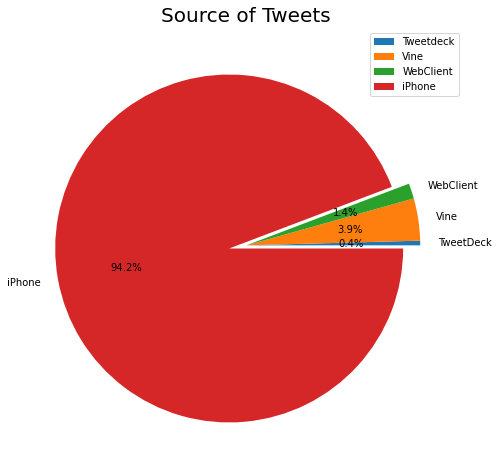

In [123]:
#plotting a piechart for source of tweets usings df_1_clean(twitter_archive)
tweet_sources = df_1_clean.groupby('source').count()[['tweet_id']]
tweet_sources.rename(columns={'tweet_id': 'source_count'}, inplace=True)
tweet_sources['source_percentage'] = tweet_sources.source_count / tweet_sources.source_count.sum() * 100
tweet_sources['source_percentage'].plot.pie(figsize=(10,8), autopct='%1.1f%%',
        explode= (0, 0, 0, 0.1))
plt.title("Source of Tweets", {'fontsize': 20})
plt.legend(["Tweetdeck", "Vine", "WebClient", "iPhone"])
plt.ylabel("")

- I used the df_1_clean(twitter_archive) dataframe to plot the pie chart for sources.
- From the plot, iPhone is the source of most tweets followed by Vine. TweetDeck has the least amount of tweets.

### Question 2. Which dog stage got the highest retweet counts and favorite counts?

<AxesSubplot:title={'center':'Average favorite counts by stages of dogs'}, ylabel='stages'>

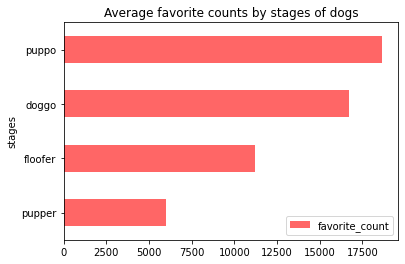

In [124]:
# we only need the rows with stages
df_stage = twitter_archive_master[twitter_archive_master["stage"].isnull()==False]
#visualization 'Average favorite counts by stages of dogs'
by_stages = df_stage.query('stage=="pupper" or stage=="doggo" or stage=="puppo" or stage=="floofer"')
favorite_counts_by_stages = pd.DataFrame(by_stages.groupby('stage').favorite_count.mean().sort_values())
favorite_counts_by_stages['stages'] = favorite_counts_by_stages.index
favorite_counts_by_stages.plot(x="stages",y='favorite_count',kind='barh',title="Average favorite counts by stages of dogs",color='r', alpha=0.6)

### Highest retweet_count and favorite_count for dog stages

- The dog stage of Puppo got the highest retweet counts and favorite counts, which is almost 3 times higher than the dog stage of pupper.

### Question 3. What is the most popular dog breeds in the dataset?

Text(0.5, 1.0, 'Top 5 dog breeds')

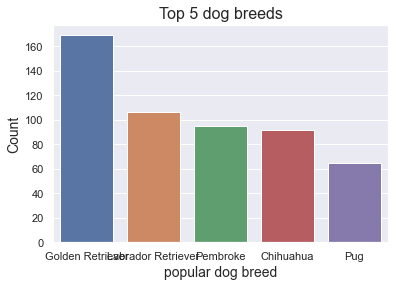

In [125]:
sns.set(style = 'darkgrid')
sorted_age = twitter_archive_master['dog_breed'].value_counts().head(5).index
sns.countplot(data = twitter_archive_master, x ='dog_breed', order = sorted_age, orient='h')
plt.xlabel('popular dog breed', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Top 5 dog breeds', fontsize=16)

- The top 5 most popuar dog breeds by WeRateDogs are  Golden Retriever, Labrador Retriver, Pembroke, Chihuahua and pug.  The top 1 being the Golden Retriever with it's popularity being almost 2 times that of Pembroke

In [126]:
# Get the value count of each 'dog_breed'
twitter_archive_master.dog_breed.value_counts()

Golden Retriever      169
Labrador Retriever    106
Pembroke               95
Chihuahua              92
Pug                    65
                     ... 
Entlebucher             1
Japanese Spaniel        1
Standard Schnauzer      1
Silky Terrier           1
Irish Wolfhound         1
Name: dog_breed, Length: 113, dtype: int64